In [1]:
import numpy as np
import os
import pandas as pd
import glob
import datetime
from multiprocessing import Pool
import concurrent.futures
from tqdm import tqdm

# Goal:
1. This notebook segment all images within the selected city
2. prioritize the selected cities: Hong Kong, London, New York, Nairobi, Sao Paulo
3. Summarize the segmentation by street segment and h3_level12 index
4. If encounter missing data, needs to use ai-research resource again.

* For the segmentation model, current uses oneFormer (https://github.com/SHI-Labs/OneFormer/blob/main/demo/README.md)

* Problem with GPU cuda toolkit version conflict
* TORCH_CUDA_ARCH_LIST="7.0 7.5" python3 setup.py install

### Current needs to rerun
* Milan

# 0. Folder Setup

In [2]:
# get all cities
folder = "/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/"
subs = os.listdir(folder)
subfiles = glob.glob(folder +"/*/*")
curated_folder = "/lustre1/g/geog_pyloo/05_timemachine/_curated"
if not os.path.exists(curated_folder):
    os.makedirs(curated_folder)

In [3]:
def get_path(subfolder):
    files = glob.glob(os.path.join(subfolder, "*/*/*.jpg"))
    return files


def get_file_size(file):
    try:
        return file, os.path.getsize(file)
    except OSError as e:
        print(f"Error: {e}")
        return file, None
class GSVSummary:
    # year1 = 2018
    # year2 = 2020
    def __init__(self, city):
        self.city = city
        self.citylower = city.lower().replace(" ", "")
        self.generalgsv = "/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/{citylower}".format(citylower=self.citylower)
        self.imgfolder = self.generalgsv + "/img_rgb"
        self.metafolder = self.generalgsv + "/gsvmeta"
        self.roadfolder = self.generalgsv + "/road"
        self.selpanopath = os.path.join(self.metafolder, "gsv_pano_label.csv")
        # self.pairpath = os.path.join(self.metafolder,
        #                              'paired_{year1}_{year2}.csv'.format(year1 = self.year1, year2 = self.year2))
        # self.today = datetime.datetime.today().strftime("%Y-%m-%d")

    def load_gsv_path(self):
        panodf = pd.read_csv(os.path.join(self.metafolder, "gsv_path.csv"))
        panodf["angle"] = panodf["path"].apply(lambda x: x.split("/")[-1][23:-4])
        panodf = panodf[panodf["angle"] != ""].reset_index(drop=True)
        panodf["angle"] = panodf["angle"].astype(int)
        panodf["panoid"] = panodf["path"].apply(lambda x: x.split("/")[-1][:22])
        return panodf

    def load_gsv_meta(self):
        metadf = pd.read_csv(os.path.join(self.metafolder, "gsv_pano.csv"))
        return metadf

    def check_gsv_download(self):

        panodf = self.load_finshed_gsv()
        # save panodf to folder
        return panodf.shape[0]

    def load_finshed_gsv(self):
        subfolders = os.listdir(self.imgfolder)
        subfolders = [os.path.join(self.imgfolder, sub) for sub in subfolders]
        pool = Pool(8)
        allfiles = []
        for ret in tqdm(pool.imap(get_path, subfolders), total=len(subfolders)):
            allfiles.append(ret)
        allfiles = [item for sublist in allfiles for item in sublist]
        panodf = pd.DataFrame(allfiles, columns=["path"])
        if panodf.shape[0] == 0:
            print("No images available.")
            return pd.DataFrame()
        else:
            panodf["panoid"] = panodf["path"].apply(
                lambda x: x.split("/")[-1].split(".")[0][:22]
            )
            panodf.to_csv(
                os.path.join(self.metafolder, 
                             "gsv_path_new.csv"
                            ), index=False
            )
        return panodf

    def load_gsv_sel_meta(self):
        metadf_sel = pd.read_csv(self.selpanopath)
        return metadf_sel

    def merge_meta(self, sel=True):
        if sel:
            metadf = self.load_gsv_sel_meta()
        else:
            metadf = self.load_gsv_meta()
        panodf = self.load_gsv_path()
        # print(panodf.head())
        # print(metadf.head())
        n = panodf.shape[0]
        print(f"Total number of panos: {n}")

        metadf_update = panodf.merge(metadf, on="panoid", how="inner")
        metadf_update.drop("geometry", axis = 1).to_csv(os.path.join(self.metafolder, 
                                          '{cityabbr}_meta.csv'.format(
                                        cityabbr = self.citylower)), index = False)
        return metadf_update
    

    def check_road(self):
        if os.path.exists(os.path.join(self.metafolder, "sentPt.p")):
            return 1
        else:
            return 0

    def check_pano(self):
        panopath = os.path.join(self.metafolder, "gsv_pano.csv")
        if os.path.exists(panopath):
            df = pd.read_csv(panopath)
            return 1, len(df)
        else:
            return 0, 0

    def get_gsv_file_size(self):
        def get_file_size(file):
            try:
                return file, os.path.getsize(file)
            except OSError as e:
                print(f"Error: {e}")
                return file, None

        gsvpath = pd.read_csv(os.path.join(self.metafolder, "gsv_path.csv"))
        files = gsvpath["path"].values
        # Store file sizes in a dictionary
        file_sizes = {}
        with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
            # The map method helps maintain the order of results
            results = executor.map(get_file_size, files)

            for file, size in results:
                if size is not None:
                    file_sizes[file] = size
                else:
                    file_sizes[file] = 0  # the file is removed

        gsvpath["size"] = gsvpath["path"].apply(lambda x: file_sizes[x])
        gsvpath.to_csv(os.path.join(self.metafolder, "gsv_path.csv"), index=False)

## 1. Construct sh files for batch processing

### 1.1 Check current progress

In [4]:
import os
import pandas as pd
import gspread
# random select the images within 5.5km of the city center
serviceaccount = "../../google_drive_personal.json"


# from oauth2client.service_account import ServiceAccountCredentials
gc = gspread.service_account(filename=serviceaccount)

def read_url(url, SHEET_NAME):
    SHEET_ID = url.split("/")[5]
    spreadsheet = gc.open_by_key(SHEET_ID)
    worksheet = spreadsheet.worksheet(SHEET_NAME)
    rows = worksheet.get_all_records()
    df_spread = pd.DataFrame(rows)
    return df_spread, worksheet


url = "https://docs.google.com/spreadsheets/d/1o5gFmZPUoDwrrbfE6M26uJF3HnEZll02ivnOxP6K6Xw/edit?usp=sharing"
SHEETNAME = "select_city_classifier"
city_meta, other_worksheet = read_url(url, SHEETNAME)
city_meta = city_meta[city_meta['City']!=''].reset_index(drop = True)
city_meta = city_meta[city_meta['GSV Downloaded']>0].reset_index(drop = True)
city_meta['city_lower'] = city_meta['City'].apply(lambda x: x.replace(" ", "").lower())
# city_meta['city_lower'].unique()

In [15]:
# check curated folder and find finished cities
finished = os.listdir(curated_folder)
city_meta['oneformer Segmentation'] = city_meta['city_lower'].apply(lambda x: x in finished)
city_meta

,City,Country,center_lat,center_lng,label,num_panoid,GSV Downloaded,oneformer Segmentation,,city_lower
0,Hindupur,India,13.822260,77.500930,41,3017,8929,True,,hindupur
1,Vijayawada,India,16.506174,80.648015,123,5397,12053,True,,vijayawada
2,Saidpur,Bangladesh,25.778031,88.897626,102,4442,12721,True,,saidpur
3,Victoria,Canada,48.428421,-123.365644,121,102539,22765,True,,victoria
4,Santiago,Chile,-33.448890,-70.669265,105,77509,29321,True,,santiago
...,...,...,...,...,...,...,...,...,...,...
122,Nagoya,Japan,35.174745,136.907539,81,1399215,5595654,True,,nagoya
123,Rio de Janeiro,Brazil,-22.911502,-43.181365,99,1452099,5806835,True,,riodejaneiro
124,Jakarta,Indonesia,-6.193973,106.822511,48,1675418,6701389,True,,jakarta
125,Bangkok,Thailand,13.756300,100.501800,9,2462549,9848301,True,,bangkok


In [17]:
city_meta['oneformer Segmentation'].value_counts()

oneformer Segmentation
True    127
Name: count, dtype: int64

### 1.2 Check whether file meta is complete for all cities 

In [22]:
cityls = city_meta[(city_meta['oneformer Segmentation']== False)&(city_meta["GSV Downloaded"]>0)]['city_lower'].unique()
print(len(cityls))

78


In [20]:
ongoing_ls = [15,18,6,'_resume']
BASHFILE = "b1_oneformer_inference_batch{FILEID}.sh"
processing = []
for i in ongoing_ls:
    bashfile = BASHFILE.format(FILEID = i)
    with open(bashfile, "r") as thefile:
        lines = thefile.readlines()
        lines = [x.strip() for x in lines]
        lines = [x.split("_curated/")[1].split(" ")[0] for x in lines if not x =='']
        processing = processing+lines

In [9]:
# cityls_to_run = [x for x in cityls if x not in processing]
cityls_to_run = city_meta[city_meta['oneformer Segmentation']==False]['City'].unique()
print("remaining to process: ", len(cityls_to_run))

remaining to process:  9


## 3. Set up bash file for oneformer prediction

In [11]:
def construct_sh(city):
    curated_folder = "/lustre1/g/geog_pyloo/05_timemachine/_curated"
    cityabbr = city.lower().replace(" ", "")
    folder = "/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb"
    meta_folder = "gsvmeta"
    path_to_checkpoint  = "../ckpt/1280x1280_250_16_swin_l_oneformer_ade20k_160k.pth"
    inputpath = os.path.join(folder, cityabbr, meta_folder, f'{cityabbr}_meta.csv')
    bash_c = f"""
    python inference.py --config-file ../configs/ade20k/swin/oneformer_swin_large_bs16_160k_1280x1280.yaml \
    --input {inputpath} \
    --outfolder {curated_folder}/{cityabbr} \
    --task semantic \
    --opts MODEL.IS_TRAIN False MODEL.IS_DEMO True MODEL.WEIGHTS {path_to_checkpoint}
    """
    print(bash_c)
    return bash_c

# for city in cityls_topredict:
N = 4
for i in range(0, N):
    with open(f"../B-timemachine/b1_oneformer_inference_0422_{i}.sh", "w") as the_file:
        for city in cityls_to_run[i::N]:
            bash_c = construct_sh(city)
            the_file.write(bash_c)


    python inference.py --config-file ../configs/ade20k/swin/oneformer_swin_large_bs16_160k_1280x1280.yaml     --input /lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/manila/gsvmeta/manila_meta.csv     --outfolder /lustre1/g/geog_pyloo/05_timemachine/_curated/manila     --task semantic     --opts MODEL.IS_TRAIN False MODEL.IS_DEMO True MODEL.WEIGHTS ../ckpt/1280x1280_250_16_swin_l_oneformer_ade20k_160k.pth
    

    python inference.py --config-file ../configs/ade20k/swin/oneformer_swin_large_bs16_160k_1280x1280.yaml     --input /lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/cleveland/gsvmeta/cleveland_meta.csv     --outfolder /lustre1/g/geog_pyloo/05_timemachine/_curated/cleveland     --task semantic     --opts MODEL.IS_TRAIN False MODEL.IS_DEMO True MODEL.WEIGHTS ../ckpt/1280x1280_250_16_swin_l_oneformer_ade20k_160k.pth
    

    python inference.py --config-file ../configs/ade20k/swin/oneformer_swin_large_bs16_160k_1280x1280.yaml     --input /lustre1/g/geog_pyloo/05_timemachine/

In [29]:
temp = pd.read_csv("/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/chicago/gsvmeta/chicago_meta.csv")
temp.head()

,path,panoid,angle,size,id,lat,lon,year,month,dist_hav,h3_res8,h3_res9,ring
0,/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_r...,s_2GNmYws-v-qmk6HI5btA,0,18453,149801.0,41.507392,-87.330192,2008.0,8.0,48221.536251,88266400adfffff,89266400ac3ffff,1.0
1,/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_r...,s_2GNmYws-v-qmk6HI5btA,90,14074,149801.0,41.507392,-87.330192,2008.0,8.0,48221.536251,88266400adfffff,89266400ac3ffff,1.0
2,/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_r...,s_2GNmYws-v-qmk6HI5btA,180,13855,149801.0,41.507392,-87.330192,2008.0,8.0,48221.536251,88266400adfffff,89266400ac3ffff,1.0
3,/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_r...,s_2GNmYws-v-qmk6HI5btA,270,11930,149801.0,41.507392,-87.330192,2008.0,8.0,48221.536251,88266400adfffff,89266400ac3ffff,1.0
4,/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_r...,-41f2OLwdPbNyz0tC0bLdQ,0,23428,3044293.0,41.732081,-88.249143,2008.0,5.0,54489.233246,882666971dfffff,892666971d7ffff,1.0


In [22]:
# for all curated ones, put in one bash file to check whether any remaining images to process
city_to_resume = city_meta[(city_meta['oneformer Segmentation']== True)].reset_index(drop = True)['City'].unique()
print(city_to_resume)
with open(f"../B-timemachine/b1_oneformer_inference_batch_resume.sh", "a") as the_file:
    for city in city_to_resume:
        bash_c = construct_sh(city)
        the_file.write(bash_c)

['Brussels' 'Gaborone' 'Sao Paulo' 'Bogotá' 'Copenhagen' 'Paris' 'Munich'
 'Berlin' 'Accra' 'Hong Kong' 'Mumbai' 'Bangalore' 'Delhi' 'Jerusalem'
 'Rome' 'Tokyo' 'Nairobi' 'Mexico City' 'Amsterdam' 'Wellington' 'Lagos'
 'Moscow' 'Singapore' 'Johannesburg' 'Seoul' 'Madrid' 'Stockholm' 'Taipei'
 'Istanbul' 'Kampala' 'Kyiv' 'Dubai' 'London' 'Miami' 'San Francisco'
 'Boston' 'Denver' 'New York' 'Los Angeles']

    python inference.py --config-file ../configs/ade20k/swin/oneformer_swin_large_bs16_160k_1280x1280.yaml     --input /lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/brussels/gsvmeta/brussels_meta.csv     --outfolder /lustre1/g/geog_pyloo/05_timemachine/_curated/brussels     --task semantic     --opts MODEL.IS_TRAIN False MODEL.IS_DEMO True MODEL.WEIGHTS ../ckpt/1280x1280_250_16_swin_l_oneformer_ade20k_160k.pth
    

    python inference.py --config-file ../configs/ade20k/swin/oneformer_swin_large_bs16_160k_1280x1280.yaml     --input /lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/

# Test OneFormer (individual demo below)
_playground/OneFormer/demo/demopy
## panoptic

In [31]:
cityabbr = "belohorizonte"
temp = pd.read_csv(f"/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/{cityabbr}/gsvmeta/{cityabbr}_meta.csv")
temp.head()

,path,panoid,size,lat,lon,year,month,id,h3_res8,h3_res9,dist_hav,data_group,ring
0,/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_r...,f2ZLXxjkm2jSYYg0aN5MFw,41946,-19.788920,-43.950674,2019.0,5.0,134109.0,88a88ccb55fffff,89a88ccb557ffff,14524.415331,train,NaN
1,/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_r...,f2ZLXxjkm2jSYYg0aN5MFw,29130,-19.788920,-43.950674,2019.0,5.0,134109.0,88a88ccb55fffff,89a88ccb557ffff,14524.415331,train,NaN
2,/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_r...,f2ZLXxjkm2jSYYg0aN5MFw,34900,-19.788920,-43.950674,2019.0,5.0,134109.0,88a88ccb55fffff,89a88ccb557ffff,14524.415331,train,NaN
3,/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_r...,f2ZLXxjkm2jSYYg0aN5MFw,49808,-19.788920,-43.950674,2019.0,5.0,134109.0,88a88ccb55fffff,89a88ccb557ffff,14524.415331,train,NaN
4,/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_r...,v69kKVvCgGBstJi24fZ4OQ,28326,-19.801781,-43.961636,2015.0,11.0,70899.0,88a88ccb59fffff,89a88ccb593ffff,13259.382046,train,NaN


/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/belohorizonte/img_rgb/7_1/3/3/v69kKVvCgGBstJi24fZ4OQ_270.jpg


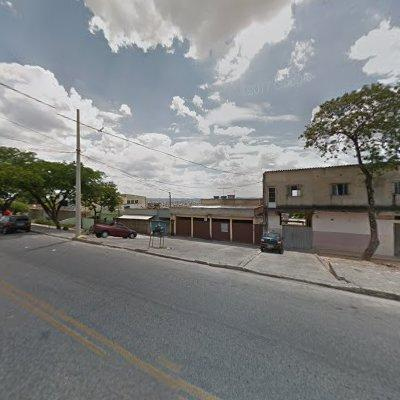

In [33]:
# load one image to test
path_to_image = temp[temp['panoid']=='v69kKVvCgGBstJi24fZ4OQ']['path'].values[0]
print(path_to_image)
from PIL import Image
Image.open(path_to_image)

In [24]:
path_to_checkpoint  = "../ckpt/250_16_swin_l_oneformer_ade20k_160k.pth"
bash_c = f"""
cd /home/yuanzf/_playground/OneFormer/demo

python demo.py --config-file ../configs/ade20k/swin/oneformer_swin_large_bs16_160k.yaml \
--input {path_to_image} \
--output {curated_folder} \
--task semantic \
--opts MODEL.IS_TRAIN False MODEL.IS_DEMO True MODEL.WEIGHTS {path_to_checkpoint}
"""
print(bash_c)


cd /home/yuanzf/_playground/OneFormer/demo

python demo.py --config-file ../configs/ade20k/swin/oneformer_swin_large_bs16_160k.yaml --input /lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/singapore/img_rgb/a_1/0/7/hdu1wXoeCoaDIT7Q7TM_Lw_0.jpg --output /lustre1/g/geog_pyloo/05_timemachine/_curated --task semantic --opts MODEL.IS_TRAIN False MODEL.IS_DEMO True MODEL.WEIGHTS ../ckpt/250_16_swin_l_oneformer_ade20k_160k.pth



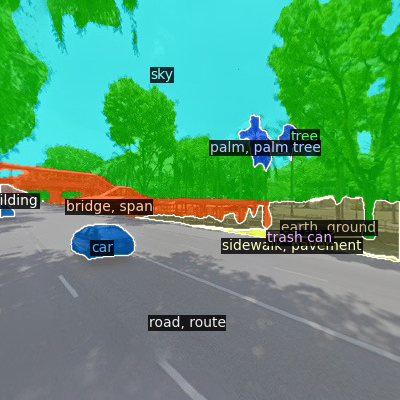

In [30]:
demo_result = "/lustre1/g/geog_pyloo/05_timemachine/_curated.png"
Image.open(demo_result)

In [ ]:
path_to_checkpoint  = "../ckpt/250_16_swin_l_oneformer_ade20k_160k.pth"
bash_c = f"""
cd /home/yuanzf/_playground/OneFormer/demo

python demo.py --config-file ../configs/ade20k/swin/oneformer_swin_large_bs16_160k_1280x1280.yaml \
--input {path_to_image} \
--output {curated_folder} \
--task panoptic \
--opts MODEL.IS_TRAIN False MODEL.IS_DEMO True MODEL.WEIGHTS {path_to_checkpoint}
"""
print(bash_c)

## semantic

In [40]:
path_to_checkpoint  = "../ckpt/250_16_swin_l_oneformer_ade20k_160k.pth"
bash_c = f"""
cd /home/yuanzf/_playground/OneFormer/demo

python demo.py --config-file ../configs/ade20k/swin/oneformer_swin_large_bs16_160k.yaml \
--input {path_to_image} \
--output {curated_folder}/semantic_testing.png \
--task semantic \
--opts MODEL.IS_TRAIN False MODEL.IS_DEMO True MODEL.WEIGHTS {path_to_checkpoint}
--confidence-threshold 0.4
"""
print(bash_c)


cd /home/yuanzf/_playground/OneFormer/demo

python demo.py --config-file ../configs/ade20k/swin/oneformer_swin_large_bs16_160k.yaml --input /lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/hongkong/img_rgb/6_1/d/6/ylbQVSC6LwrP8nrcV_k28g_180.jpg --output /lustre1/g/geog_pyloo/05_timemachine/_curated/semantic_testing.png --task semantic --opts MODEL.IS_TRAIN False MODEL.IS_DEMO True MODEL.WEIGHTS ../ckpt/250_16_swin_l_oneformer_ade20k_160k.pth



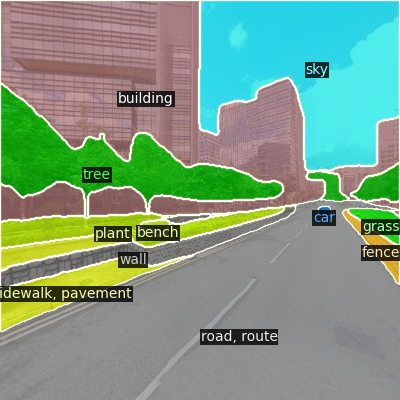

In [41]:
demo_result = "/lustre1/g/geog_pyloo/05_timemachine/_curated/semantic_testing.png"
Image.open(demo_result)

In [48]:
path_to_image1 = df.loc[210, 'path']
path_to_image2 = df.loc[510, 'path']

In [49]:
path_to_checkpoint  = "../ckpt/1280x1280_250_16_swin_l_oneformer_ade20k_160k.pth"
bash_c = f"""
cd /home/yuanzf/_playground/OneFormer/demo

python demo.py --config-file ../configs/ade20k/swin/oneformer_swin_large_bs16_160k_1280x1280.yaml \
--input {path_to_image1} {path_to_image2} \
--output {curated_folder} \
--task semantic \
--opts MODEL.IS_TRAIN False MODEL.IS_DEMO True MODEL.WEIGHTS {path_to_checkpoint}
"""
print(bash_c)


cd /home/yuanzf/_playground/OneFormer/demo

python demo.py --config-file ../configs/ade20k/swin/oneformer_swin_large_bs16_160k_1280x1280.yaml --input /lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/hongkong/img_rgb/6_1/d/6/ylbQVSC6LwrP8nrcV_k28g_180.jpg /lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/hongkong/img_rgb/6_1/d/1/iIFcqz53uY33gcaa9-FPZg_180.jpg --output /lustre1/g/geog_pyloo/05_timemachine/_curated --task semantic --opts MODEL.IS_TRAIN False MODEL.IS_DEMO True MODEL.WEIGHTS ../ckpt/1280x1280_250_16_swin_l_oneformer_ade20k_160k.pth



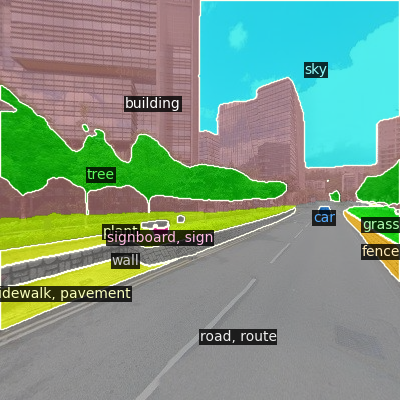

In [47]:
demo_result = "/lustre1/g/geog_pyloo/05_timemachine/_curated/semantic_testing_1280.png"
Image.open(demo_result)

# Convert the segmentation into list of images in and out

In [ ]:
python inference.py --config-file ../configs/ade20k/swin/oneformer_swin_large_bs16_160k_1280x1280.yaml --input /lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/hongkong/gsvmeta/hongkong_meta.csv --outfolder /lustre1/g/geog_pyloo/05_timemachine/_curated/hongkong --task semantic --opts MODEL.IS_TRAIN False MODEL.IS_DEMO True MODEL.WEIGHTS ../ckpt/1280x1280_250_16_swin_l_oneformer_ade20k_160k.pth

In [80]:
# london with two batches
path_to_checkpoint  = "../ckpt/1280x1280_250_16_swin_l_oneformer_ade20k_160k.pth"
inputpath1 = os.path.join(folder, cityabbr, meta_folder, f'{cityabbr}_meta_10k.csv')
inputpath2 = os.path.join(folder, cityabbr, meta_folder, f'{cityabbr}_meta_over10k.csv')

bash_c = f"""
python inference.py --config-file ../configs/ade20k/swin/oneformer_swin_large_bs16_160k_1280x1280.yaml \
--input {inputpath1} \
--outfolder {curated_folder}/{cityabbr} \
--task semantic \
--opts MODEL.IS_TRAIN False MODEL.IS_DEMO True MODEL.WEIGHTS {path_to_checkpoint}
"""
print(bash_c)

bash_c = f"""
python inference.py --config-file ../configs/ade20k/swin/oneformer_swin_large_bs16_160k_1280x1280.yaml \
--input {inputpath2} \
--outfolder {curated_folder}/{cityabbr} \
--task semantic \
--opts MODEL.IS_TRAIN False MODEL.IS_DEMO True MODEL.WEIGHTS {path_to_checkpoint}
"""
print(bash_c)


python inference.py --config-file ../configs/ade20k/swin/oneformer_swin_large_bs16_160k_1280x1280.yaml --input /lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/london/gsvmeta/london_meta_10k.csv --outfolder /lustre1/g/geog_pyloo/05_timemachine/_curated/london --task semantic --opts MODEL.IS_TRAIN False MODEL.IS_DEMO True MODEL.WEIGHTS ../ckpt/1280x1280_250_16_swin_l_oneformer_ade20k_160k.pth


python inference.py --config-file ../configs/ade20k/swin/oneformer_swin_large_bs16_160k_1280x1280.yaml --input /lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/london/gsvmeta/london_meta_over10k.csv --outfolder /lustre1/g/geog_pyloo/05_timemachine/_curated/london --task semantic --opts MODEL.IS_TRAIN False MODEL.IS_DEMO True MODEL.WEIGHTS ../ckpt/1280x1280_250_16_swin_l_oneformer_ade20k_160k.pth



## Testing Prediction Results

In [17]:
import glob
curated_folder = "/lustre1/g/geog_pyloo/05_timemachine/_curated"

In [18]:
def get_result(cityabbr, curated_folder = curated_folder, f_suffixes = "*panoptic.csv"):
    outfolder = f"{curated_folder}/{cityabbr}"
    seg_file = glob.glob(os.path.join(outfolder, f_suffixes))
    panoptic_df = []
    for p in seg_file:
        temp = pd.read_csv(p)
        panoptic_df.append(temp)
    panoptic_df = pd.concat(panoptic_df).reset_index(drop = True)
    return panoptic_df

cityabbr = "london"
panoptic_df = get_result(cityabbr, f_suffixes = "*panoptic.csv")
seg_df = get_result(cityabbr, f_suffixes = "*seg.csv")

In [26]:
panoptic_df.head()

,id,isthing,category_id,area,img
0,1,False,6,64799,lplCrINNTIpv4NmMmIwksw_0
1,2,False,4,48996,lplCrINNTIpv4NmMmIwksw_0
2,3,True,32,693,lplCrINNTIpv4NmMmIwksw_0
3,4,False,0,6093,lplCrINNTIpv4NmMmIwksw_0
4,5,True,20,1333,lplCrINNTIpv4NmMmIwksw_0


In [19]:
panoptic_df['img'].nunique()

1524409

In [24]:
panoptic_df[panoptic_df['category_id']==20].groupby('img')['id'].size().sort_values() # car: result is slightly different from the segmetnation results

img
---dBf3I-RAe01Gw6EmRdw_0      1
eUuCfDhE58kBg_SPf7q0qg_180    1
eUuCfDhE58kBg_SPf7q0qg_0      1
eUtcqxnsJMftj1PyL9aERA_90     1
eUtcqxnsJMftj1PyL9aERA_270    1
                             ..
0I4x55NziTL6AcGbvaDASQ_270    3
xaMFq7EvjE1D8fMeeImJpQ_90     3
TryzBlWgBTGcWmX5ZHGBPA_270    3
CO-Cj5QGnMDSXBjQF4z3yg_0      3
3G0Km4JfJ45E4TjpPHBQ0Q_270    3
Name: id, Length: 1189019, dtype: int64

In [25]:
seg_df[seg_df['labels']==20].groupby('img').size() # car

img
---dBf3I-RAe01Gw6EmRdw_0      1
---dBf3I-RAe01Gw6EmRdw_180    1
---dBf3I-RAe01Gw6EmRdw_270    1
---dBf3I-RAe01Gw6EmRdw_90     1
--0ZHhdGbmdR86hA8gtE1g_0      1
                             ..
zzxkfrmFHLxQAf3Au54QsA_90     1
zzyVlWz4x1_PzB2c-gkesg_180    1
zzyVlWz4x1_PzB2c-gkesg_270    1
zzyuLX9EqRvEZ6r2xGMAPg_270    1
zzyuLX9EqRvEZ6r2xGMAPg_90     1
Length: 1233557, dtype: int64

In [16]:
seg_df.shape

(2589626, 3)